# Training the data on standford sentiment treebank dataset

In [2]:
# Reference - https://www.kaggle.com/docs/tpu
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [4]:
# Configure TPU
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)


# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 32 * tpu_strategy.num_replicas_in_sync

In [23]:
import os
import time
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Getting the data directories
data_dir = tf.keras.utils.get_file(
      fname='SST-2.zip',
      origin='https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8',
      extract=True)
data_dir = os.path.join(os.path.dirname(data_dir), 'SST-2')

7446528/7439277 [==============================] - 0s 0us/step


In [7]:
# directories for train, validation and test set
train = os.path.join(data_dir, "train.tsv")
valid = os.path.join(data_dir, "dev.tsv")
test = os.path.join(data_dir, "test.tsv")

In [8]:
# Loading the train, valid and test data
train_dataset = pd.read_csv(train, sep='\t')
valid_dataset = pd.read_csv(valid, sep='\t')
test_dataset = pd.read_csv(test, sep='\t')

# EDA of the SST data
We will be focusing on train and validation dataset because the train dataset will be the amazon review dataset

In [24]:
# Merging validation and train for EDA
merge = [train_dataset, valid_dataset]
df_data = pd.concat(merge)

print ('total data',df_data.shape)

df_data.head(10)

total data (68221, 2)


,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
5,that 's far too tragic to merit such superfici...,0
6,demonstrates that the director of such hollywo...,1
7,of saucy,1
8,a depressed fifteen-year-old 's suicidal poetry,0
9,are more deeply thought through than in most `...,1


In [25]:
# Train data information
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68221 entries, 0 to 871
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  68221 non-null  object
 1   label     68221 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [26]:
# Checking for Null values
print ("Null values in the dataset : ", df_data.isnull().sum(axis = 0))

Null values in the dataset :  sentence    0
label       0
dtype: int64


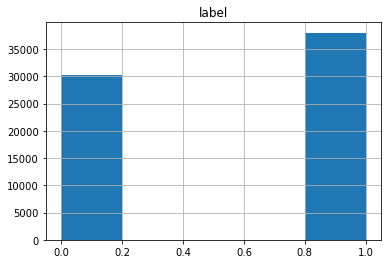

In [27]:
# Distribution of labels
hist = df_data.hist(bins=5)

In [39]:
text=df_data['sentence'].to_list()
text
def listToString(list):
    str1 = " "
    return (str1.join(list))


convertedStr = listToString(text)

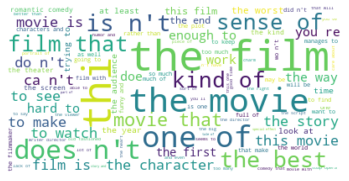

In [40]:
# Word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(convertedStr)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Preparing the Data for training

In [43]:
# Assigning variables for sentences and labels
train_reviews = train_dataset['sentence'].values
train_sentiments = train_dataset['label'].values

valid_reviews = valid_dataset['sentence'].values
valid_sentiments = valid_dataset['label'].values

test_reviews = test_dataset['sentence'].values


train_reviews.shape, valid_reviews.shape, test_reviews.shape

((67349,), (872,), (1821,))

In [41]:
# Intializing  Pre-trained tokenizer 
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [44]:
# Creating input features for bert model
import tqdm

def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded
MAX_SEQ_LENGTH = 500

train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_reviews, 
                                                                      max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, valid_reviews, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)
test_features_ids,test_features_masks = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 1821/1821 [00:01<00:00, 920.12it/s]


Train Features: (67349, 500) (67349, 500)
Val Features: (872, 500) (872, 500)
Test Features: (1821, 500) (1821, 500)


In [45]:
# Create TensorFlow datasets for better performance
train_ds = (
    tf.data.Dataset
    .from_tensor_slices(((train_features_ids, train_features_masks), train_sentiments))
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
    
valid_ds = (
    tf.data.Dataset
    .from_tensor_slices(((val_features_ids, val_features_masks), valid_sentiments))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


In [46]:
def get_training_model():
    inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
    inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
    inputs = [inp_id, inp_mask]

    hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
    pooled_output = hidden_state[:, 0]    
    dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
    drop1 = tf.keras.layers.Dropout(0.25)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(0.25)(dense2)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                               epsilon=1e-08), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [47]:
# Compile the model with TPU Strategy
with tpu_strategy.scope():
    model = get_training_model()
    
# Train the model
start = time.time()
model.fit(train_ds, 
    validation_data=valid_ds,
    epochs=3)
end = time.time()
print(f"Training takes {end-start} seconds.")


Epoch 1/3
264/264 [==============================] - 113s 427ms/step - accuracy: 0.8796 - loss: 0.2828 - val_accuracy: 0.8991 - val_loss: 0.2541
Epoch 2/3
264/264 [==============================] - 89s 337ms/step - accuracy: 0.9437 - loss: 0.1539 - val_accuracy: 0.8945 - val_loss: 0.2958
Epoch 3/3
264/264 [==============================] - 89s 336ms/step - accuracy: 0.9598 - loss: 0.1145 - val_accuracy: 0.8956 - val_loss: 0.3149
Training takes 332.39013171195984 seconds.


In [49]:
#Saving the weights of the model
model.save_weights('distillbert_ft_wts.h5')